In [15]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix


In [18]:
#Load clean data

df = pd.read_csv("../data/cleaned_transactions.csv")
df.shape


(6362620, 13)

In [ ]:
#Filter: Focus on 'TRANSFER' & 'CASH_OUT'
df = df[df['type'].isin(['TRANSFER', 'CASH_OUT'])].copy()
df.shape


In [ ]:
#Feature Engineering
df['isHighAmount'] = df['amount'] > df['amount'].quantile(0.99)
df['balanceChange'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['hour'] = df['step'] % 24
df['day'] = df['step'] // 24


In [ ]:
#5. Standardize Features
features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'balanceChange']
scaler = StandardScaler()
X = scaler.fit_transform(df[features])


In [ ]:
#6. Isolation Forest (Unsupervised Anomaly Detection)

model = IsolationForest(n_estimators=100, contamination=0.001, random_state=42)
df['anomaly_score'] = model.fit_predict(X)
df['isAnomaly'] = (df['anomaly_score'] == -1).astype(int)


In [ ]:
#7. Visualize Anomaly Score Distribution
sns.countplot(x='isAnomaly', data=df, palette='coolwarm')
plt.title("Isolation Forest - Anomaly Predictions")
plt.xticks([0, 1], ["Normal", "Anomaly"])
plt.show()


In [ ]:
#8. Evaluate Against Actual Labels
print("Confusion Matrix:")
print(confusion_matrix(df['isFraud'], df['isAnomaly']))

print("\nClassification Report:")
print(classification_report(df['isFraud'], df['isAnomaly']))

In [ ]:
#9. Show Top Anomalous Transactions
df[df['isAnomaly'] == 1].sort_values(by='amount', ascending=False).head(10)


In [ ]:
# Group by sender and compute average time gap
df['prev_step'] = df.groupby('nameOrig')['step'].shift(1)
df['step_gap'] = df['step'] - df['prev_step']
df['step_gap'].fillna(0, inplace=True)


In [ ]:
#11. Step Gap vs Fraud 
sns.boxplot(x='isFraud', y='step_gap', data=df)
plt.title("Step Gap (Velocity) vs Fraud")
plt.show()


/var/folders/zw/q57nvchx4px_sjq5v4zf2nwc0000gn/T/ipykernel_48901/2255462060.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/Users/mahalakshmirajabattula/Library/Mobile Documents/com~apple~CloudDocs/transaction_forensic_project/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


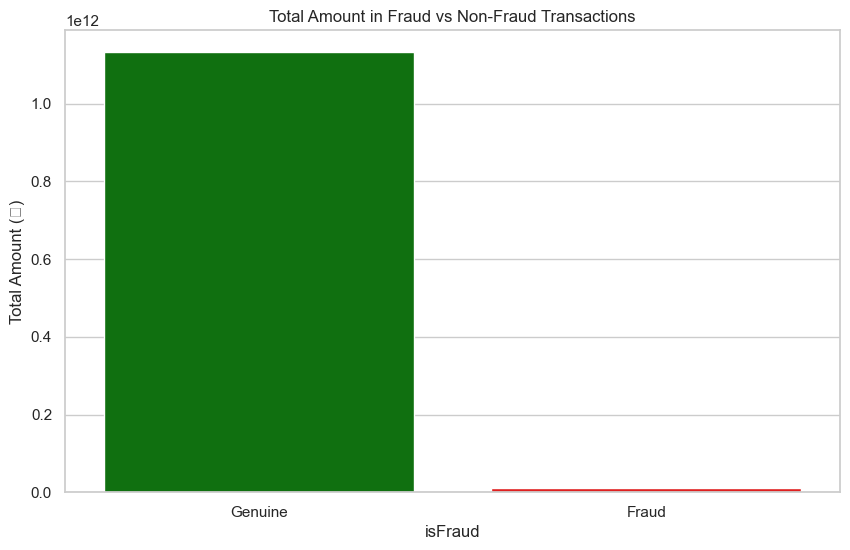

In [19]:
#Visualize Fraud Amount vs Non-Fraud
sns.barplot(
    data=df.groupby("isFraud")["amount"].sum().reset_index(),
    x="isFraud",
    y="amount",
    palette=["green", "red"]
)
plt.xticks([0, 1], ["Genuine", "Fraud"])
plt.title("Total Amount in Fraud vs Non-Fraud Transactions")
plt.ylabel("Total Amount (₹)")
plt.show()


/Users/mahalakshmirajabattula/Library/Mobile Documents/com~apple~CloudDocs/transaction_forensic_project/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


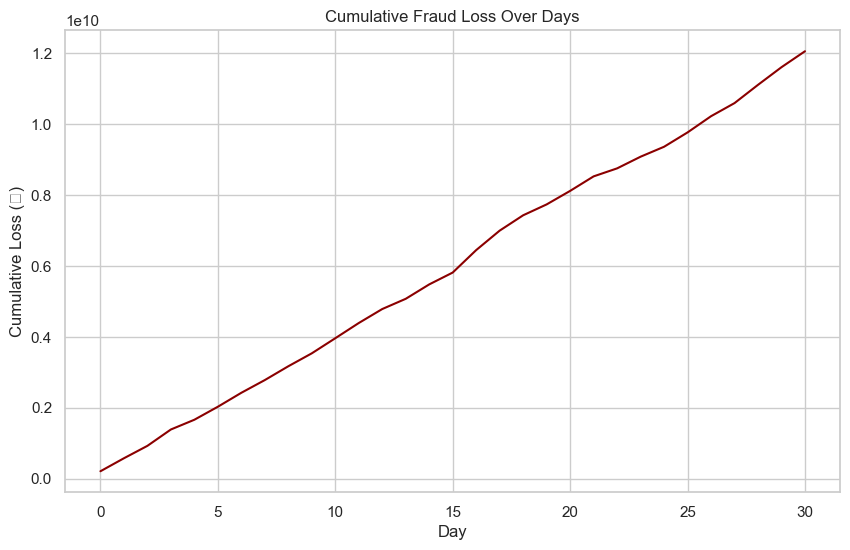

In [20]:
#Create a Cumulative Fraud Over Time Plot
df['fraud_amount'] = df['amount'] * df['isFraud']
daily_loss = df.groupby(df['step'] // 24)['fraud_amount'].sum().cumsum()

plt.plot(daily_loss, color='darkred')
plt.title("Cumulative Fraud Loss Over Days")
plt.xlabel("Day")
plt.ylabel("Cumulative Loss (₹)")
plt.grid(True)
plt.show()
